<a href="https://colab.research.google.com/github/dominik-kuehn/Final_Project_TC5/blob/main/its_the_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors



#from numba import jit

In [157]:
### Geometry and constants ###
Lx = 2e-3
Ly = 2e-3
Lslot = 5e-4
Lcoflow = 5e-4

vy_slot = 1
vy_coflow = 0.2
Tslot = 300
Tcoflow = 300

rho = 1.1614
nu = 15e-6
D = nu
a = nu
cp = 1.2e3
Ta = 1e4
A = 1.1e8
nu_CH4, nu_O2, nu_N2, nu_H2O, nu_CO2 = -1, -2, 0, 2, 1
dhN2, dhO2, dhCH4, dhH2O, dhCO2 = 0, 0, -74.9e3, -241.818e3, -393.52e3


### simulation parameters ###
n = 20
nx, ny = n, n
dx, dy = Lx/(nx-1), Ly/(ny-1)
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
print("dx=",dx)

nxLslot = int(Lslot/dx) #right index border of slot
nxLcoflow = int((Lslot+Lcoflow)/dx) #right index border of coflow

x_grid, y_grid = np.meshgrid(x, y)


### Euler forward ###
dt = np.min([dx/(10*np.sqrt(vy_slot**2)),dx**2*1/(10*nu)])      #CFL (C=1/5) et Fourier Fo = 1/5
print("dt=",dt)
Delta_T = 10e-3
nt = int(Delta_T/dt)
print("nt=",nt)


dx= 0.00010526315789473685
dt= 1.0526315789473684e-05
nt= 950


In [158]:
### vel boundary conditions ###
def boundaryConditions(v_roll=np.array([[]]), x=False, y=False):
    if x:
        v_roll[0,:] = np.zeros(v_roll[0,:].shape)    #no v_x at the top and bottom walls and inlets
        v_roll[-1,:] = np.zeros(v_roll[-1,:].shape)
        v_roll[:,0]= np.zeros(v_roll[:,0].shape) #u = 0 at solid wall left
    elif y:
        v_roll[0,nxLcoflow:-1] = np.zeros(v_roll[-1,nxLcoflow:-1].shape)                     #vy = 0 at no slip wall top
        v_roll[-1,nxLcoflow:-1] = np.zeros(v_roll[-1,nxLcoflow:-1].shape)                    #...and bottom
        v_roll[0,nxLslot:nxLcoflow] = vy_coflow*np.ones(v_roll[-1,nxLslot:nxLcoflow].shape)  #vy = vy_coflow at cowflow opening
        v_roll[-1,nxLslot:nxLcoflow] = -vy_coflow*np.ones(v_roll[-1,nxLslot:nxLcoflow].shape)
        v_roll[0,0:nxLslot] = vy_slot*np.ones(v_roll[-1,0:nxLslot].shape)                    #vy = vy_slot at slot opening
        v_roll[-1,0:nxLslot] = -vy_slot*np.ones(v_roll[-1,0:nxLslot].shape)
        v_roll[:,0]= v_roll[:,1]     #grad_x v = 0 at slip wall left
    else:
        raise ValueError('Not indicated whether v is in x or in y.')
    return v_roll




## velocity deriv ###
def indp1x(v=np.array([[]]), x=False, y=False):    #indexshift plus 1, corresponds to mathematical x[i-1]
    v_roll = np.roll(v, 1, axis=1)
    return boundaryConditions(v_roll, x, y)

def indm1x(v=np.array([[]]), x=False, y=False):    #indexshift minus 1, corresponds to mathematical x[i+1]
    v_roll = np.roll(v, -1, axis=1)
    v_roll = boundaryConditions(v_roll, x, y)
    v_roll[:,-1]= v[:,-1]    #ouflow continuity
    return v_roll

def indp1y(v=np.array([[]]), x=False, y=False):
    v_roll = np.roll(v, 1, axis=0)
    return boundaryConditions(v_roll, x, y)

def indm1y(v=np.array([[]]), x=False, y=False):
    v_roll = np.roll(v, -1, axis=0)
    return boundaryConditions(v_roll, x, y)


#@jit(nopython=True)
def dphidx(v=np.array([[]]), vx=np.array([[]]), x=False, y=False):
    return 1/dx*(np.heaviside(vx,1)*(v-indm1x(v, x, y)) + np.heaviside(-1*vx,0)*(indp1x(v, x, y)-v))

#@jit(nopython=True)
def dphidy(v=np.array([[]]), vy=np.array([[]]), x=False, y=False):
    return 1/dy*(np.heaviside(vy,1)*(v-indm1y(v, x, y)) + np.heaviside(-1*vy,0)*(indp1y(v, x, y)-v))

#@jit(nopython=True)
def d2phidx2(v=np.array([[]]), x=False, y=False):
    return (1/dx**2)*(indm1x(v, x, y)-2*v+indp1x(v, x, y))

#@jit(nopython=True)
def d2phidy2(v=np.array([[]]), x=False, y=False):
    return 1/dy**2*(indm1y(v, x, y)-2*v+indp1y(v, x, y))

#@jit(nopython=True)
def dphidt(v, vx=np.array([[]]), vy=np.array([[]]), x=False, y=False):
    return nu*(d2phidx2(v, x, y)+d2phidy2(v, x, y))-vx*dphidx(v, vx, x, y)-vy*dphidy(v, vy, x, y)


vx_init = boundaryConditions(np.zeros(x_grid.shape), x=True)
vy_init = boundaryConditions(np.zeros(x_grid.shape), y=True)
vx_evol = np.zeros((nt,n,n))
vx_evol[0] = vx_init
vy_evol = np.zeros((nt,n,n))
vy_evol[0] = vy_init


for k in range(nt-1): #k instead of n -> n=20 and not 17 :)

    vx_previous = vx_evol[k]
    vy_previous = vy_evol[k]
    vx = vx_previous+dt*dphidt(vx_previous, vx_previous, vy_previous, x=True)
    vy = vy_previous+dt*dphidt(vy_previous, vx_previous, vy_previous, y=True)
    vx_evol[k+1] = vx
    vy_evol[k+1] = vy


### animation ###
#fig, ax = plt.subplots()
#ax.imshow(phi_evol[20])
#plt.show()

#def movie(i):
#    ax.cla()
#    sns.relplot(data = vx_evol[i,:,:],
#                ax = ax)

#grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.2}
#fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw = grid_kws, figsize = (12, 8))
#anim = FuncAnimation(fig = fig, func = movie, frames = nt, interval = 0, blit = False)


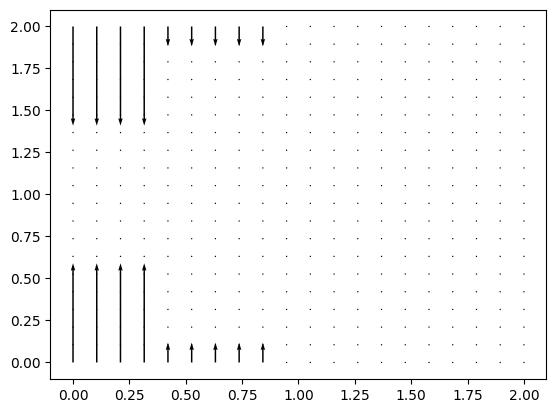

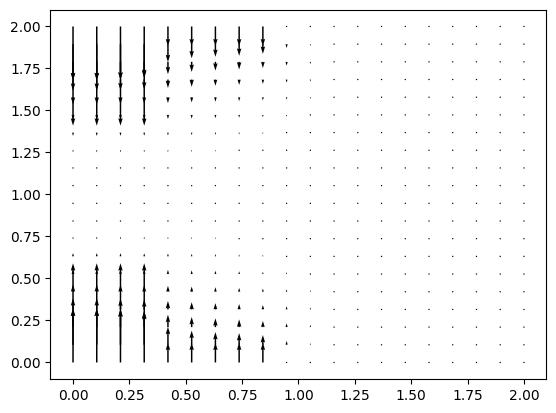

Velocity profile at x_i= 14


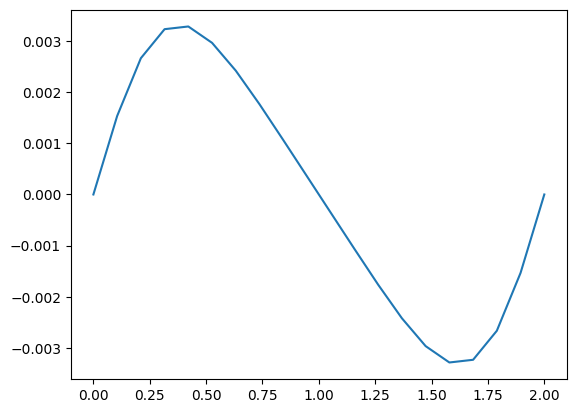

In [159]:
M = np.hypot(vx_evol[0], vy_evol[0]) #for later ;) Pretty colours
plt.quiver(x_grid*1e3, y_grid*1e3, vx_evol[0], vy_evol[0], scale=5) #1e3 for axes in mm, shows initial velocity field
plt.show()
plt.quiver(x_grid*1e3, y_grid*1e3, vx_evol[-1], vy_evol[-1], scale=5) #shows final velocity field
plt.show()

print('Velocity profile at x_i=', int(1.5e-3/dx))
vy_profile = vy[:,int(1.5e-3/dx)]
plt.plot(y*1e3, vy_profile) #show v_y at coflow region to verify proper function of advection part

#so far everything works. Advection without pressure: Check

In [160]:
### Add pressure term to advection ###


## pressure boundary conditions ##
def pBoundaryConditions(p_roll=np.array([[]]), x=False, y=False):
    if x:
        p_roll[:,0]= p_roll[:,1] #d_x P = 0 at left wall
        p_roll[:,-1]=np.zeros(p_roll[:,-1].shape) #exterior pressure effect at p_roll[:,-1]
        p_roll[:,-2]=p_roll[:,-1]
        #p_roll[:,-1]=p_roll[:,-2]
    elif y:
        p_roll[0,:]= p_roll[1,:]     #d_y P = 0 at top wall
        p_roll[-1,:]= p_roll[-2,:]     #d_y P = 0 at bottom wall
    else:
        raise ValueError('Not indicated whether p-roll is in x or in y.')
    return p_roll


## pressure deriv ##
def pIndp1x(p=np.array([[]])):    #indexshift plus 1, corresponds to mathematical x[i-1]
    p_roll = np.roll(p, 1, axis=1)
    return pBoundaryConditions(p_roll, x=True)

def pIndm1x(p=np.array([[]])):    #indexshift minus 1, corresponds to mathematical x[i+1]
    p_roll = np.roll(p, -1, axis=1)
    p_roll = pBoundaryConditions(p_roll, x=True)
    return p_roll

def pIndp1y(p=np.array([[]])):
    p_roll = np.roll(p, 1, axis=0)
    return pBoundaryConditions(p_roll, y=True)

def pIndm1y(p=np.array([[]])):
    p_roll = np.roll(p, -1, axis=0)
    return pBoundaryConditions(p_roll, y=True)


def dPdx(p):
  dPdx = np.zeros(p.shape)
  pp = pIndm1x(p) #p_i_plus_1
  pm = pIndp1x(p) #p_i_minus_1
  dPdx[:,1:-1] = (pp[:,1:-1]-pm[:,1:-1])/(2*dx) #second order centered solver, perhaps theres better?
  dPdx[:,0] = np.zeros(p[:,0].shape)#(-3*p[:,0]+4*p[:,1]-p[:,2])/(2*dx)  #second order non-centered solver for Von-Neumann boundary condition
  dPdx[:,-1] = np.zeros(p[:,-1].shape) #(3*p[:,-1]-4*p[:,-2]+p[:,-3])/(2*dx)  #''
  return dPdx


def dPdy(p):
  dPdy = np.zeros(p.shape)
  pp = pIndm1y(p) #p_j_plus_1
  pm = pIndp1y(p) #p_j_minus_1
  dPdy[1:-1,:] = (pp[1:-1,:]-pm[1:-1,:])/(2*dy) #second order centered solver, perhaps theres better?
  dPdy[0,:] = np.zeros(p[0,:].shape)#(-3*p[0,:]+4*p[1,:]-p[2,:])/(2*dy)  #second order non-centered solver for Von-Neumann boundary condition
  dPdy[-1,:] = np.zeros(p[-1,:].shape)#(3*p[-1,:]-4*p[-2,:]+p[-3,:])/(2*dy)  #''
  return dPdy


## Find dxP and dyP -- Attention at borders!
## add missing p-terms to all vx and vy timesteps

In [161]:
def dvxdx(v=np.array([[]])):
    return (indm1x(v, x=True)-indp1x(v, x=True))/(2*dx)

def dvydy(v=np.array([[]])):
    return (indm1y(v, y=True)-indp1y(v, y=True))/(2*dy)


def laplace_gauss_seidel_solver(p, vx, vy, tolerance=1e-5, max_iterations=1000):
    rows, cols = p.shape
    n_iter = 0
    #S = rho/dt*(dphidx(vx, vx, x=True)+dphidy(vy, vy, y=True))
    S = rho/dt*(dvxdx(vx)+dvydy(vy))


    for h in range(max_iterations):
        p_old = np.copy(p)
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                p[j,i] = 0.25 * (p[j, i-1] + p[j, i+1] + p[j-1, i] + p[j+1, i] - (dx**2)*S[j,i])
        p = pBoundaryConditions(p, x=True)
        p = pBoundaryConditions(p, y=True)
        difference = np.max(np.abs(p - p_old))
        if difference < tolerance:
            n_iter = h+1
            break

    return p, n_iter

In [162]:
p_init = pBoundaryConditions(np.ones(x_grid.shape), x=True) # p_init = 1 !
p_init = pBoundaryConditions(p_init, y=True)
p_evol = np.zeros((nt,n,n))
p_evol[0] = np.copy(p_init)
pressure = np.copy(p_init)

vx_star = np.copy(vx_evol)
vy_star = np.copy(vy_evol)
vx_evol2 = np.zeros(vx_evol.shape) #..._evol2 records any changes to ..._evol due to the added pressure term with Gauss-Seidel later on
vy_evol2 = np.zeros(vy_evol.shape)
n_iterations = np.zeros(nt)


for k in range(nt-1):
    pressure, n_iterations[k+1] = laplace_gauss_seidel_solver(p_evol[k], vx_star[k+1], vy_star[k+1])
    pressure = pBoundaryConditions(pressure, x=True)
    p_evol[k+1] = pBoundaryConditions(pressure, y=True)

    vx_evol2[k+1] = vx_star[k+1]-dt/rho*dPdx(p_evol[k+1])
    vy_evol2[k+1] = vy_star[k+1]-dt/rho*dPdy(p_evol[k+1])

    vx_evol2[k+1] = boundaryConditions(vx_evol2[k+1],x=True)
    vy_evol2[k+1] = boundaryConditions(vy_evol2[k+1],y=True)

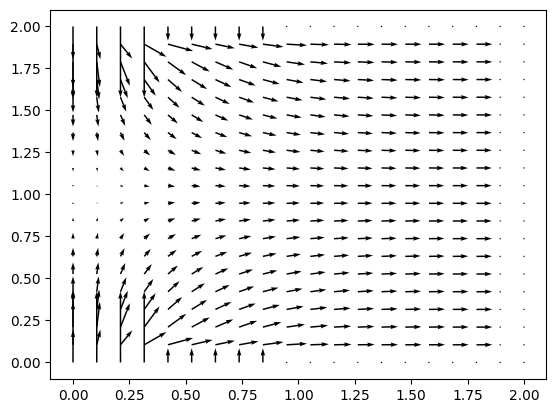

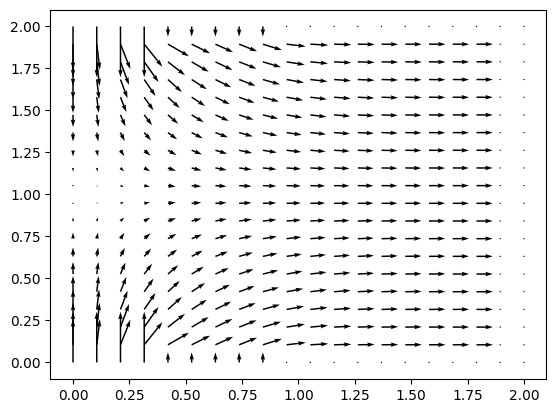

Still bizarre velocity, even with centered velocity derivative in GS


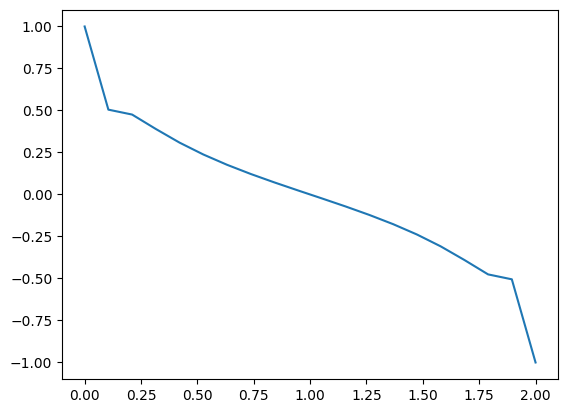

In [173]:
plt.quiver(x_grid*1e3, y_grid*1e3, vx_evol2[1], vy_evol2[1]) #1e3 for axes in mm, shows initial velocity field
plt.show()
plt.quiver(x_grid*1e3, y_grid*1e3, vx_evol2[-1], vy_evol2[-1]) #shows final velocity field
plt.show()

plt.plot(y*1e3, vy_evol2[-1][:,0]) #show v_y at coflow region to verify proper function of advection part
print("Still bizarre velocity, even with centered velocity derivative in GS")
#plt.plot(y*1e3, p_evol[-1])

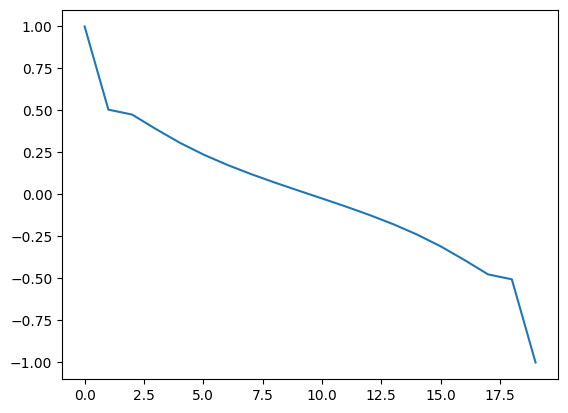

In [172]:
#plt.plot(derives)
plt.plot(vy_evol2[-1][:,0])
plt.show()
#print(n_iterations)

In [ ]:
plt.quiver(x_grid*1e3, y_grid*1e3, vx_evol2[-1], vy_evol2[-1]) #shows final velocity field
plt.show()
print("vx_max =",np.max(vx_evol2[-1]))
print("vy_max =",np.max(vy_evol2[-1]))
plt.imshow(p_evol[-1])
plt.colorbar()
plt.show()

- The max values of vx and vy are coherent with the incoming fluid velocity, the direction of the fluid velocity is also good !!!!!!!!!!!!!
- The boundary conditions of P are finally respected at all time step which is wunderbar :)
- Maybe problem : the pressure always goes negative whatever the initial value of P and $P_{out}$, I am gonna ask Lucien.

In [ ]:
plt.imshow(p_evol[1])
plt.colorbar()
plt.show()

plt.imshow(p_evol[-1])
plt.colorbar()
plt.show()

In [ ]:
### vel boundary conditions ###
def TboundaryConditions(T_roll=np.array([[]])):
    T_roll[0,nxLslot:nxLcoflow] = Tcoflow*np.ones(T_roll[-1,nxLslot:nxLcoflow].shape)  #T = T_coflow at opening
    T_roll[-1,nxLslot:nxLcoflow] = Tcoflow*np.ones(T_roll[-1,nxLslot:nxLcoflow].shape)
    T_roll[0,0:nxLslot] = Tslot*np.ones(T_roll[0,0:nxLslot].shape)                    #T = T_slot at opening
    T_roll[-1,0:nxLslot] = Tslot*np.ones(T_roll[-1,0:nxLslot].shape)
    T_roll[:,0] = T_roll[:,1]
    T_roll[:,-1] = T_roll[:,-2]
    T_roll[0,:] = T_roll[1,:]
    T_roll[-1,:] = T_roll[-2,:]
    return T_roll

## temp deriv ###
def indp1x(t=np.array([[]]), x=False, y=False):    #indexshift plus 1, corresponds to mathematical x[i-1]
    t_roll = np.roll(t, 1, axis=1)
    return TboundaryConditions(t_roll)

def indm1x(t=np.array([[]]), x=False, y=False):    #indexshift minus 1, corresponds to mathematical x[i+1]
    t_roll = np.roll(t, -1, axis=1)
    return TboundaryConditions(t_roll)

def indp1y(t=np.array([[]]), x=False, y=False):
    t_roll = np.roll(t, 1, axis=0)
    return TboundaryConditions(t_roll)

def indm1y(t=np.array([[]]), x=False, y=False):
    t_roll = np.roll(t, -1, axis=0)
    return TboundaryConditions(t_roll)

In [ ]:
T_init = TboundaryConditions(np.ones(x_grid.shape))
T = np.ones((nt,n,n))
T[0] = T_init
temperature = np.copy(T_init)

for k in range(nt-1):

    temperature = T[k]+dt*dphidt(T[k], vx_evol2[k], vy_evol[k], x=True)
    T[k+1] = TboundaryConditions(temperature)

In [ ]:
plt.imshow(T[-1],norm=colors.LogNorm())
plt.colorbar()
plt.show()

In [ ]:
### species fraction boundary conditions ###
def speciesBoundaryConditions(species_roll=np.array([[]]), methane = False, o2 = False, nitrogen = False, h2o = False, co2 = False):
    if nitrogen:
        species_roll[0,nxLslot:nxLcoflow] = np.ones(species_roll[-1,nxLslot:nxLcoflow].shape)  #
        species_roll[-1,nxLslot:nxLcoflow] = np.ones(species_roll[-1,nxLslot:nxLcoflow].shape)
        species_roll[0,0:nxLslot] = 0.8*np.ones(species_roll[0,0:nxLslot].shape)                    #
        species_roll[-1,0:nxLslot] = np.zeros(species_roll[-1,0:nxLslot].shape)
    elif o2:
        species_roll[0,nxLslot:nxLcoflow] = np.zeros(species_roll[-1,nxLslot:nxLcoflow].shape)  #
        species_roll[-1,nxLslot:nxLcoflow] = np.zeros(species_roll[-1,nxLslot:nxLcoflow].shape)
        species_roll[0,0:nxLslot] = 0.2*np.ones(species_roll[0,0:nxLslot].shape)                    #
        species_roll[-1,0:nxLslot] = np.zeros(species_roll[-1,0:nxLslot].shape)
    elif methane:
        species_roll[0,nxLslot:nxLcoflow] = np.zeros(species_roll[-1,nxLslot:nxLcoflow].shape)  #
        species_roll[-1,nxLslot:nxLcoflow] = np.zeros(species_roll[-1,nxLslot:nxLcoflow].shape)
        species_roll[0,0:nxLslot] = np.zeros(species_roll[0,0:nxLslot].shape)                    #
        species_roll[-1,0:nxLslot] = np.ones(species_roll[-1,0:nxLslot].shape)
    elif h2o:
        species_roll[0,nxLslot:nxLcoflow] = np.zeros(species_roll[-1,nxLslot:nxLcoflow].shape)  #
        species_roll[-1,nxLslot:nxLcoflow] = np.zeros(species_roll[-1,nxLslot:nxLcoflow].shape)
        species_roll[0,0:nxLslot] = np.zeros(species_roll[0,0:nxLslot].shape)                    #
        species_roll[-1,0:nxLslot] = np.zeros(species_roll[-1,0:nxLslot].shape)
    elif co2:
        species_roll[0,nxLslot:nxLcoflow] = np.zeros(species_roll[-1,nxLslot:nxLcoflow].shape)  #
        species_roll[-1,nxLslot:nxLcoflow] = np.zeros(species_roll[-1,nxLslot:nxLcoflow].shape)
        species_roll[0,0:nxLslot] = np.zeros(species_roll[0,0:nxLslot].shape)                    #
        species_roll[-1,0:nxLslot] = np.zeros(species_roll[-1,0:nxLslot].shape)
    else :
        raise("Specify calculated species by setting one of the species [air, nitrogen, water, h2o, co2] to True!")

    #grad_perp Y_k = 0:
    species_roll[:,0] = species_roll[:,1]
    species_roll[:,-1] = species_roll[:,-2]
    species_roll[1,:] = species_roll[0,:] #changing index 1 and not 0 because 0 is set to slot and coflow values, which shan't be overwritten
    species_roll[-2,:] = species_roll[-1,:] # "   "   "


    return species_roll

In [ ]:

## velocity deriv ###
def indp1x_c(v=np.array([[]]), methane = False, o2 = False, nitrogen = False, h2o = False, co2 = False):    #indexshift plus 1, corresponds to mathematical x[i-1]
    v_roll = np.roll(v, 1, axis=1)
    return speciesBoundaryConditions(v_roll,  methane , o2 , nitrogen, h2o, co2)

def indm1x_c(v=np.array([[]]), methane = False, o2 = False, nitrogen = False, h2o = False, co2 = False):    #indexshift minus 1, corresponds to mathematical x[i+1]
    v_roll = np.roll(v, -1, axis=1)
    v_roll = speciesBoundaryConditions(v_roll,  methane , o2 , nitrogen , h2o, co2)
    v_roll[:,-1]= v[:,-1]    #ouflow continuity
    return v_roll

def indp1y_c(v=np.array([[]]), methane = False, o2 = False, nitrogen = False, h2o = False, co2 = False):
    v_roll = np.roll(v, 1, axis=0)
    return speciesBoundaryConditions(v_roll, methane , o2 , nitrogen , h2o, co2)

def indm1y_c(v=np.array([[]]), methane = False, o2 = False, nitrogen = False, h2o = False, co2 = False):
    v_roll = np.roll(v, -1, axis=0)
    return speciesBoundaryConditions(v_roll,  methane , o2 , nitrogen, h2o, co2 )


def dphidx_c(v=np.array([[]]), vx=np.array([[]]), methane = False, o2 = False, nitrogen = False, h2o = False, co2 = False):
    return 1/dx*(np.heaviside(vx,1)*(v-indm1x_c(v, methane , o2 , nitrogen, h2o, co2)) + np.heaviside(-1*vx,0)*(indp1x_c(v, methane , o2 , nitrogen, h2o, co2)-v))

def dphidy_c(v=np.array([[]]), vy=np.array([[]]), methane = False, o2 = False, nitrogen = False, h2o = False, co2 = False):
    return 1/dy*(np.heaviside(vy,1)*(v-indm1y_c(v, methane , o2 , nitrogen, h2o, co2)) + np.heaviside(-1*vy,0)*(indp1y_c(v, methane , o2 , nitrogen, h2o, co2)-v))

def d2phidx2_c(v=np.array([[]]), methane = False, o2 = False, nitrogen = False, h2o = False, co2 = False):
    return (1/dx**2)*(indm1x_c(v, methane , o2 , nitrogen, h2o, co2)-2*v+indp1x_c(v, methane , o2 , nitrogen, h2o, co2))

def d2phidy2_c(v=np.array([[]]), methane = False, o2 = False, nitrogen = False, h2o = False, co2 = False):
    return 1/dy**2*(indm1y_c(v, methane , o2 , nitrogen, h2o, co2)-2*v+indp1y_c(v, methane , o2 , nitrogen, h2o, co2))

def dphidt_c(v, vx=np.array([[]]), vy=np.array([[]]), methane = False, o2 = False, nitrogen = False, h2o = False, co2 = False):
    return nu*(d2phidx2_c(v, methane , o2 , nitrogen, h2o, co2)+d2phidy2_c(v, methane , o2 , nitrogen, h2o, co2))-vx*dphidx_c(v, vx, methane , o2 , nitrogen, h2o, co2)-vy*dphidy_c(v, vy,methane , o2 , nitrogen, h2o, co2)

In [ ]:
y_methane_init = speciesBoundaryConditions(np.zeros(x_grid.shape), methane =True)
y_methane = np.zeros((nt,n,n))
y_methane[0] = y_methane_init
methane = np.copy(y_methane_init)

y_nitrogen_init = speciesBoundaryConditions(np.zeros(x_grid.shape), nitrogen =True)
y_nitrogen = np.zeros((nt,n,n))
y_nitrogen[0] = y_nitrogen_init
nitrogen = np.copy(y_nitrogen_init)

y_h2o_init = speciesBoundaryConditions(np.zeros(x_grid.shape), h2o =True)
y_h2o = np.zeros((nt,n,n))
y_h2o[0] = y_h2o_init
h2o = np.copy(y_h2o_init)

y_co2_init = speciesBoundaryConditions(np.zeros(x_grid.shape), co2 =True)
y_co2 = np.zeros((nt,n,n))
y_co2[0] = y_co2_init
co2 = np.copy(y_co2_init)

y_o2_init = speciesBoundaryConditions(np.zeros(x_grid.shape), o2 =True)
y_o2 = np.zeros((nt,n,n))
y_o2[0] = y_o2_init
o2 = np.copy(y_o2_init)

for k in range(nt-1):

    o2 = y_o2[k]+dt*dphidt_c(y_o2[k], vx_evol2[k], vy_evol[k], o2=True)
    y_o2[k+1] = speciesBoundaryConditions(o2, o2 = True)

    methane = y_methane[k]+dt*dphidt_c(y_methane[k], vx_evol2[k], vy_evol[k], methane=True)
    y_methane[k+1] = speciesBoundaryConditions(methane, methane = True)

    nitrogen = y_nitrogen[k]+dt*dphidt_c(y_nitrogen[k], vx_evol2[k], vy_evol[k], nitrogen=True)
    y_nitrogen[k+1] = speciesBoundaryConditions(nitrogen, nitrogen = True)


In [ ]:
plt.imshow(y_methane[0], origin="lower")
plt.colorbar()
plt.show()
plt.imshow(y_methane[-1], origin="lower",norm=colors.LogNorm() )
plt.colorbar()
plt.show()

In [ ]:
print(y_o2.shape)

In [ ]:
plt.imshow(y_nitrogen[0], origin="lower")
plt.colorbar()
plt.show()
plt.imshow(y_nitrogen[-1], origin="lower",norm=colors.LogNorm())
plt.colorbar()
plt.show()

In [ ]:
###Dominik tries again###

### chemistry ###

#species:
#k | name
#-----------
#0 | methane
#1 | O2
#2 | N2
#3 | water
#4 | CO2

#molar masses
W_CH4 = 16
W_O2 = 16
W_N2 = 14
W_H2O = 10
W_CO2 = 44
W_k = np.array([W_CH4, W_O2, W_N2, W_H2O, W_CO2])

#enthalpies
dh_CH4 = -74.9e3
dh_O2 = 0
dh_N2 = 0
dh_H2O = -241.818e3
dh_CO2 = -393.52e3
dh_k = np.array([dh_CH4, dh_O2, dh_N2, dh_H2O, dh_CO2])

#stochiometry
nu_CH4 = -1
nu_O2 = -2
nu_N2 = 0
nu_H20 = 2
nu_CO2 = 1
nu_k = np.array([nu_CH4, nu_O2, nu_N2, nu_H2O, nu_CO2])

#progress rate/Arrhenius law
Q = 1.1e8*(rho*y_methane/W_CH4)*(rho*y_o2/W_O2)**2*np.exp(-1e4/T)    #(concentration of O2)^2 has to be calculated but i dont know how exactly
print(Q.shape)

wdot_k = np.array([W_k[k]*nu_k[k]*Q for k in range(5)])

wdot_T = -np.sum([dh_k[k]/W_k[k]*wdot_k[k,:,:,:] for k in range(5)],axis=0)

dYk_dt = wdot_k/rho
dT_dt=wdot_T/rho/cp

print("k",wdot_k.shape)
print("T",wdot_T.shape)


T2 = np.ones((nt,n,n)) #T avec la chimie
T2[0] = TboundaryConditions(1.7e3*np.ones(x_grid.shape))
#T2[0][:,10:11]=1e3*np.ones(T2[0][:,10:11].shape)
y_co2 = np.zeros((nt,n,n))
y_h2o = np.zeros((nt,n,n))
N_chem_steps=500
liste =[]

# combustion test #
#y_methane[0]=0.1*np.ones(y_methane[0].shape)
#y_o2[0]=0.8*np.ones(y_o2[0].shape)
#y_nitrogen[0]=0.1*np.ones(y_nitrogen[0].shape)

for t in range(nt-1):

  y_methane_old = y_methane[t]
  y_o2_old = y_o2[t]
  y_h2o_old = y_h2o[t]
  y_co2_old = y_co2[t]
  T2_old = T2[t]

  for t_chem in range(N_chem_steps):

    Q = 1.1e8*(rho*y_methane_old/W_CH4)*(rho*y_o2_old/W_O2)**2*np.exp(-1e4/T2[t])
    wdot_k = np.array([W_k[k]*nu_k[k]*Q for k in range(5)])
    wdot_T = -np.sum([dh_k[k]/W_k[k]*wdot_k[k] for k in range(5)])

    dYk_dt = wdot_k/rho
    dT_dt=wdot_T/rho/cp

    methane = y_methane_old+dt/N_chem_steps*dYk_dt[0]
    y_methane_old = speciesBoundaryConditions(methane, methane = True)    #check if bound cond necessary between chem steps too, or if chem happens too fast for influx of new gas and thus bound cond are to be applied after entire chem cycle
    #y_methane_old = methane

    o2 = y_o2_old+dt/N_chem_steps*dYk_dt[1]
    y_o2_old = speciesBoundaryConditions(o2, o2 = True)
    #y_o2_old = o2

    h2o = y_h2o_old+dt/N_chem_steps*dYk_dt[3]
    y_h2o_old = speciesBoundaryConditions(h2o, h2o = True)
    #y_h2o_old = h2o

    co2 = y_co2_old+dt/N_chem_steps*dYk_dt[4]
    y_co2_old = speciesBoundaryConditions(co2, co2 = True)
    #y_co2_old = co2

    temp = T2_old + dt/N_chem_steps*dT_dt
    T2_old = TboundaryConditions(temp)

  methane = y_methane_old+dt*dphidt_c(y_methane_old, vx_evol2[t], vy_evol2[t], methane=True)
  y_methane[t+1] = speciesBoundaryConditions(methane, methane = True)

  o2 = y_o2_old+dt*dphidt_c(y_o2_old, vx_evol2[t], vy_evol2[t], o2=True)
  y_o2[t+1] = speciesBoundaryConditions(o2, o2 = True)

  h2o = y_h2o_old+dt*dphidt_c(y_h2o_old, vx_evol2[t], vy_evol2[t], h2o=True)
  y_h2o[t+1] = speciesBoundaryConditions(h2o, h2o = True)

  co2 = y_co2_old+dt*dphidt_c(y_co2_old, vx_evol2[t], vy_evol2[t], co2=True)
  y_co2[t+1] = speciesBoundaryConditions(co2, co2 = True)

  liste.append(t)

  temperature = T2_old+dt*dphidt(T2[t], vx_evol2[t], vy_evol2[t], y=True)
  T2[t+1] = TboundaryConditions(temperature)



print(nt)
print(len(liste))
print(temperature.shape)

(13537, 20, 20)
k (5, 13537, 20, 20)
T (13537, 20, 20)


ValueError: operands could not be broadcast together with shapes (20,20) (30,30) 

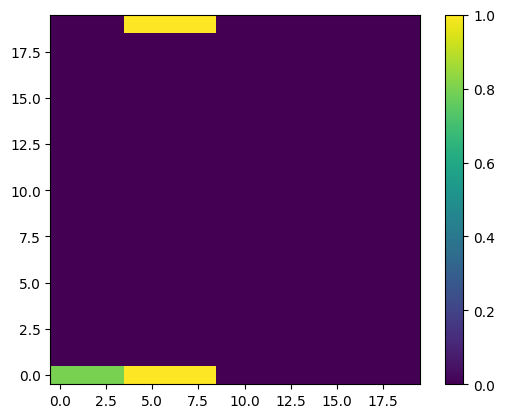

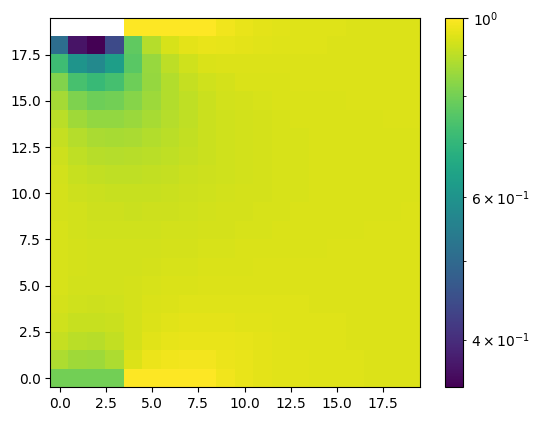

In [ ]:
plt.imshow(y_nitrogen[0], origin="lower")
plt.colorbar()
plt.show()
plt.imshow(y_nitrogen[-1]/np.max(y_nitrogen[-1]), origin="lower",norm=colors.LogNorm())
plt.colorbar()
plt.show()

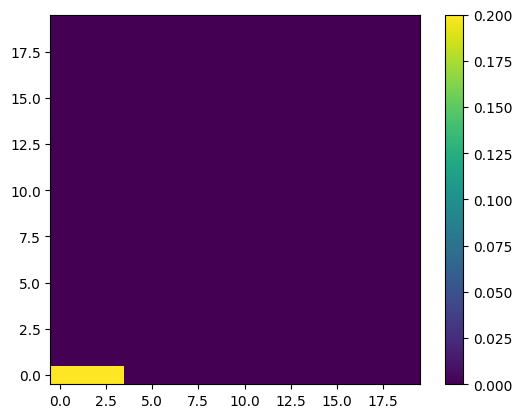

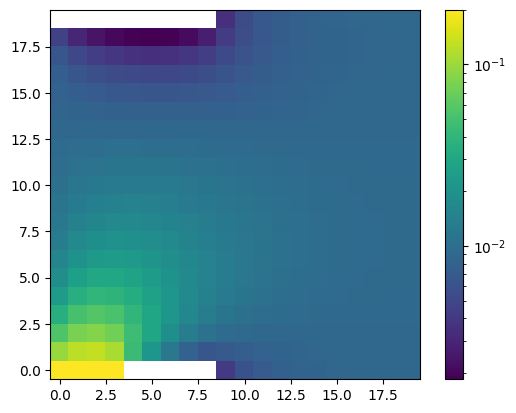

In [ ]:
plt.imshow(y_o2[0], origin="lower")
plt.colorbar()
plt.show()
plt.imshow(y_o2[-1], origin="lower",norm=colors.LogNorm())
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(y_methane[0], origin="lower")
plt.colorbar()
plt.show()
plt.imshow(y_methane[-1], origin="lower",norm=colors.LogNorm())
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(y_co2[0], origin="lower")
plt.colorbar()
plt.show()
plt.imshow(y_co2[-1], origin="lower",norm=colors.LogNorm())
plt.colorbar()
plt.show()

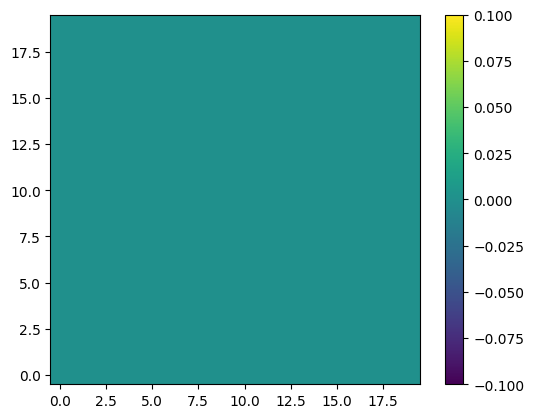

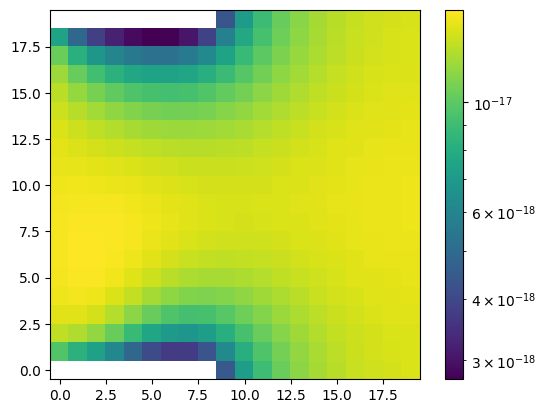

In [ ]:
plt.imshow(y_h2o[0], origin="lower")
plt.colorbar()
plt.show()
plt.imshow(y_h2o[-1], origin="lower",norm=colors.LogNorm())
plt.colorbar()
plt.show()

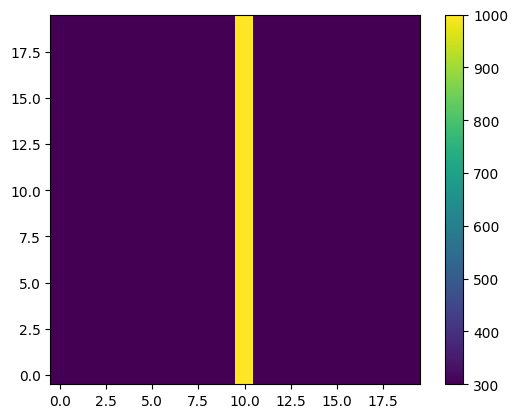

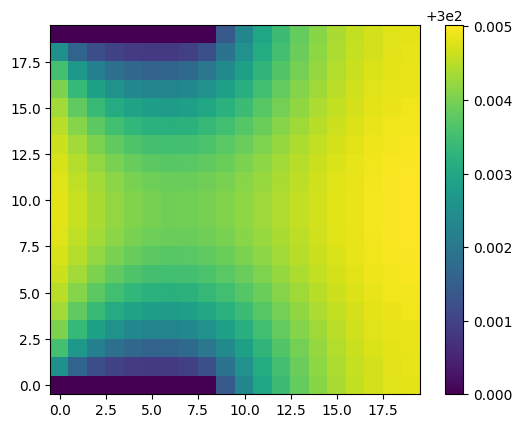

In [ ]:
plt.imshow(T2[0], origin="lower")
plt.colorbar()
plt.show()
plt.imshow(T2[-1], origin="lower")#,norm=colors.LogNorm())
plt.colorbar()
plt.show()

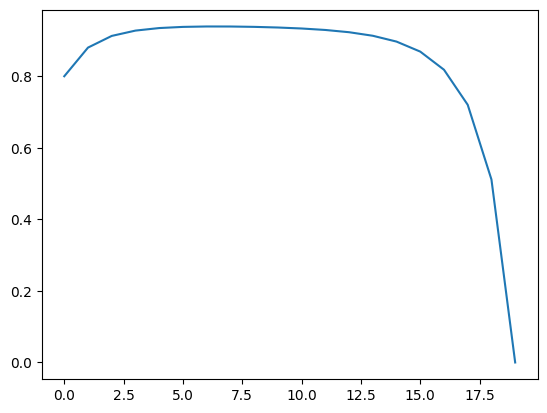

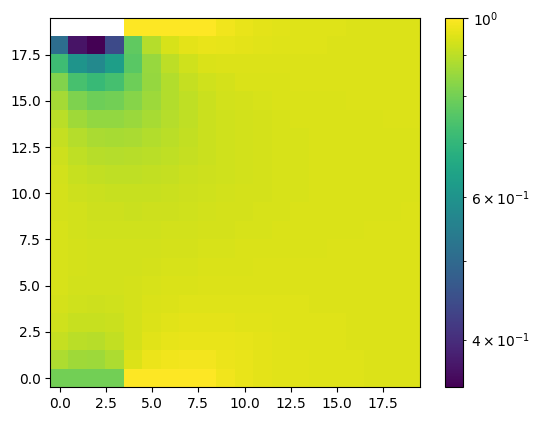

In [ ]:
###diffusive thickness###

plt.plot(y_nitrogen[-1][:,0])#/0.8)
plt.show()
plt.imshow(y_nitrogen[-1]/np.max(y_nitrogen[-1]), origin="lower",norm=colors.LogNorm())
plt.colorbar()
plt.show()